<a target="_blank" href="https://colab.research.google.com/github/sakarimov/Basic-ML-Model/blob/main/JanKenPon%20CNN%20Image%20Recognizer.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **Student Name** : Sulthan A. Karimov
# **Username** : sulthankarimov
# **Email** : sulthankarimov@gmail.com

In [1]:
!pip install split-folders[full] matplotlib jupyter_http_over_ws imutils

In [2]:
# import all needed libraries
import zipfile, os, shutil, splitfolders, re, random
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from imutils import paths
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.backend import clear_session
from sklearn.metrics import classification_report


2024-06-13 06:38:22.014324: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
# defining directories
local_dir = 'datasets/images/'
dataset_name = 'rockpaperscissors'
local_data = local_dir + dataset_name
local_zip = local_data + '.zip'

In [25]:
# dowload dataset (pass if exist)
!test -f $local_zip || wget --no-check-certificate \
 https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip \
 -O $local_zip

In [26]:
# extract dataset
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(local_dir)
zip_ref.close()

In [27]:
# prepare train & validation split
shutil.rmtree(local_data + '/rps-cv-images')
os.remove(local_data + '/README_rpc-cv-images.txt')
print(os.listdir(local_data))

base_dir = local_dir + '/rps'
if os.path.exists(base_dir) == True:
  shutil.rmtree(base_dir)

splitfolders.ratio(local_data, base_dir, ratio=(.6,.4))
train_dir = os.path.join(base_dir, 'train')
print('amount of training sample : ', sum(len(files) for _, _, files in os.walk(re.escape(base_dir) + r'/train')))
validation_dir = os.path.join(base_dir, 'val')
print('amount of validation sample : ', sum(len(files) for _, _, files in os.walk(re.escape(base_dir) + r'/val')))

['paper', 'rock', 'scissors']


Copying files: 2188 files [00:00, 5302.33 files/s]

amount of training sample :  1312
amount of validation sample :  876


In [28]:
# prepare test folder for classification report
files_list = []

for root, dirs, files in os.walk(local_data):
  for dir in dirs:
    results = os.walk(local_data + '/' + dir)
    for result in results:
      cat_list = []
      for file in result[2]:
        if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
          cat_list.append(os.path.join(root + '/' + dir, file))
    files_list.append(cat_list)

for imgs in files_list:
  category = re.findall('(?<=rs\/).*?(?=\/)', imgs[0])[0]
  filesToCopy = random.sample(imgs, 4)
  destPath = base_dir + '/test/' + str(category)
  if os.path.isdir(destPath) == False:
    os.makedirs(destPath)
  for file in filesToCopy:
    shutil.copy(file, destPath)

test_dir = os.path.join(base_dir, 'test')

In [29]:
# directory summary
print(os.listdir(train_dir))
print(os.listdir(validation_dir))
print(os.listdir(test_dir))

['paper', 'rock', 'scissors']
['paper', 'rock', 'scissors']
['paper', 'rock', 'scissors']


In [9]:
# preparing generator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest',
    preprocessing_function = preprocess_input,
)

test_datagen = ImageDataGenerator(
    rescale = 1./255)

In [30]:
# defining rgb mean for every generator
mean = np.array([123.68, 116.779, 103.939], dtype = 'float32')
train_datagen.mean = mean
test_datagen.mean = mean

In [32]:
# flow data to generator
BATCH_SIZE = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
)

totalTrain = len(list(paths.list_images(train_dir)))
totalVal = len(list(paths.list_images(validation_dir)))
totalTest = len(list(paths.list_images(test_dir)))

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.
Found 12 images belonging to 3 classes.


In [12]:
# preparing baseModel
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

2024-06-13 06:38:33.026430: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-13 06:38:33.036228: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-13 06:38:33.036873: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [13]:
# freeze hidden layers to preserve model features
for layer in baseModel.layers:
    layer.trainable = False

In [14]:
# prepare callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

EarlyStop = EarlyStopping(
    monitor = 'val_loss',
    patience = 4,
    verbose = 1,
    restore_best_weights = True,
    min_delta = 0.1
)

ModelCP = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 1,
    verbose = 1
)

callbacks = [EarlyStop, ModelCP]

In [15]:
# compile the model with frozen layers
print("[INFO] compiling model...")
opt = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
print("[INFO] training head...")
H = model.fit(
	x=train_generator,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=validation_generator,
	validation_steps=totalVal // BATCH_SIZE,
	epochs=25,
    callbacks=callbacks,
)

[INFO] compiling model...
[INFO] training head...
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718260718.096354    2416 service.cc:145] XLA service 0x7e2f6c00bac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718260718.096393    2416 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 960M, Compute Capability 5.0
2024-06-13 06:38:38.140178: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-13 06:38:38.387163: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-06-13 06:38:42.864229

41/41 ━━━━━━━━━━━━━━━━━━━━ 65s 764ms/step - accuracy: 0.3194 - loss: 1.6568 - val_accuracy: 0.3299 - val_loss: 1.1905 - learning_rate: 1.0000e-04
Epoch 2/25


2024-06-13 06:39:38.617402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 06:39:38.617449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 06:39:38.617466: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1113105719973859051
2024-06-13 06:39:38.617484: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17891322345123413466
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, trac


Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 324ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.0495 - learning_rate: 1.0000e-04
Epoch 3/25


2024-06-13 06:39:51.896922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 06:39:51.896973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 06:39:51.896987: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1113105719973859051
2024-06-13 06:39:51.897001: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17891322345123413466


41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 762ms/step - accuracy: 0.4824 - loss: 1.1331 - val_accuracy: 0.6551 - val_loss: 0.8608 - learning_rate: 5.0000e-05
Epoch 4/25


2024-06-13 06:40:25.878261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 06:40:25.878307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 06:40:25.878325: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1113105719973859051
2024-06-13 06:40:25.878349: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17891322345123413466


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8333 - val_loss: 0.7623 - learning_rate: 5.0000e-05
Epoch 5/25


2024-06-13 06:40:26.110588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 06:40:26.110637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 06:40:26.110670: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1113105719973859051
2024-06-13 06:40:26.110696: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17891322345123413466


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.5609 - loss: 0.9040
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 789ms/step - accuracy: 0.5616 - loss: 0.9034 - val_accuracy: 0.3414 - val_loss: 0.9531 - learning_rate: 5.0000e-05
Epoch 6/25


2024-06-13 06:41:01.193988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 06:41:01.194027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 6: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.4488 - learning_rate: 2.5000e-05
Epoch 7/25


2024-06-13 06:41:01.433249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 06:41:01.433288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 06:41:01.433300: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1113105719973859051
2024-06-13 06:41:01.433317: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17891322345123413466


41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 851ms/step - accuracy: 0.4162 - loss: 1.0887 - val_accuracy: 0.9155 - val_loss: 0.7140 - learning_rate: 1.2500e-05
Epoch 8/25


2024-06-13 06:41:38.865435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 06:41:38.865565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.6769 - learning_rate: 1.2500e-05
Epoch 9/25


2024-06-13 06:41:39.121906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 06:41:39.121993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.8038 - loss: 0.7564
Epoch 9: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 879ms/step - accuracy: 0.8039 - loss: 0.7561 - val_accuracy: 0.8727 - val_loss: 0.6917 - learning_rate: 1.2500e-05
Epoch 10/25


2024-06-13 06:42:17.951701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 06:42:17.951753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 06:42:17.951777: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1113105719973859051
2024-06-13 06:42:17.951811: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17891322345123413466


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.6729 - learning_rate: 6.2500e-06
Epoch 11/25


2024-06-13 06:42:18.198832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 06:42:18.198885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 06:42:18.198902: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1113105719973859051
2024-06-13 06:42:18.198925: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17891322345123413466


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.7804 - loss: 0.7520
Epoch 11: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 869ms/step - accuracy: 0.7808 - loss: 0.7515 - val_accuracy: 0.8692 - val_loss: 0.6797 - learning_rate: 6.2500e-06
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 7.


In [16]:
# create classification_report for trained model
print("[INFO] evaluating after fine-tuning network head...")
test_generator.reset()
predIdxs = model.predict(x=test_generator,
	steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(test_generator.classes, predIdxs,
	target_names=test_generator.class_indices.keys()))

[INFO] evaluating after fine-tuning network head...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00         4
        rock       1.00      0.75      0.86         4
    scissors       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92      0.92        12



In [17]:
# recreate model with unfrozen layers
clear_session()
train_generator.reset()
validation_generator.reset()
for layer in baseModel.layers[15:]:
	layer.trainable = True

In [21]:
# recompile and retrain the model after unfreezing layers
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
H = model.fit(
	x=train_generator,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=validation_generator,
	validation_steps=totalVal // BATCH_SIZE,
	epochs=20,
    callbacks=callbacks,
)

[INFO] re-compiling model...
Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 841ms/step - accuracy: 0.8991 - loss: 0.3942 - val_accuracy: 0.8449 - val_loss: 0.3809 - learning_rate: 1.0000e-04
Epoch 2/20


2024-06-13 06:53:29.167122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-06-13 06:53:29.167245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1072 - learning_rate: 1.0000e-04
Epoch 3/20


2024-06-13 06:53:29.745362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 06:53:29.745418: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1113105719973859051
2024-06-13 06:53:29.745443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.8902 - loss: 0.3041
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 861ms/step - accuracy: 0.8907 - loss: 0.3038 - val_accuracy: 0.9537 - val_loss: 0.1826 - learning_rate: 1.0000e-04
Epoch 4/20


2024-06-13 06:54:08.699110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 06:54:08.699156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1245 - learning_rate: 5.0000e-05
Epoch 5/20


2024-06-13 06:54:08.943815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 06:54:08.943913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9678 - loss: 0.1691
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 972ms/step - accuracy: 0.9676 - loss: 0.1694 - val_accuracy: 0.9595 - val_loss: 0.1536 - learning_rate: 2.5000e-05
Epoch 6/20


2024-06-13 06:54:52.113182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 06:54:52.113229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 06:54:52.113261: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17891322345123413466



Epoch 6: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1329 - learning_rate: 1.2500e-05
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 2.


2024-06-13 06:54:52.364841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 06:54:52.364891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 06:54:52.364915: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1113105719973859051
2024-06-13 06:54:52.364932: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17891322345123413466


In [22]:
# create classification_report for full model
print("[INFO] evaluating after fine-tuning network...")
test_generator.reset()
predIdxs = model.predict(x=test_generator,
	steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(test_generator.classes, predIdxs,
	target_names=test_generator.class_indices.keys()))

[INFO] evaluating after fine-tuning network...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00         4
        rock       1.00      1.00      1.00         4
    scissors       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


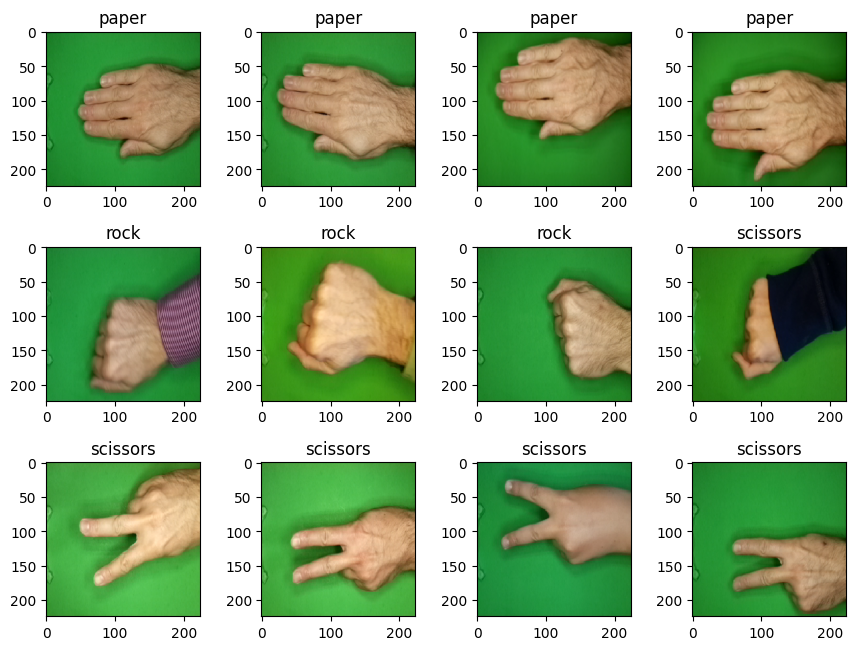

In [33]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

testdir = test_dir
uploaded = list(paths.list_images(testdir))
fig = plt.figure(figsize= (10, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for i in range(len(uploaded)):
    path = uploaded[i]
    img = image.load_img(path, target_size = (224,224))

    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(img)
    images = image.img_to_array(img)
    images = np.expand_dims(images, axis=0)
    images = preprocess_input(images)
    pred = model.predict(images)
    ax.title.set_text(list(train_generator.class_indices.keys())[np.argmax(pred, axis = 1)[0]])
